In [2]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [3]:
unique_data = df.drop_duplicates(subset='sippid').dropna(subset=['rm_lfp'])
print(unique_data.shape)

(2816, 231)


In [4]:
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in


In [5]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(unique_data['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(unique_data[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(unique_data['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    sippid_dummies = pd.get_dummies(unique_data['sippid'], prefix='sippid', drop_first=True)
    month_dummies = pd.get_dummies(unique_data['ref_month'], prefix='month', drop_first=True)
    edu_dummies = pd.get_dummies(unique_data['lt_college'], prefix='college', drop_first=True)
    age_group_dummies = pd.get_dummies(unique_data['age_group'],prefix='age', drop_first=True)  # Dummies for age groups
    recession_dummies = pd.get_dummies(unique_data['recession_birth'],prefix='recession', drop_first=True)  # Dummies for recession years

    
    age_recession_interactions = pd.DataFrame(index=unique_data.index)
    for age_col in age_group_dummies.columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{age_col}_recession_{recession_col}'
            age_recession_interactions[interaction_name] = age_group_dummies[age_col] * recession_dummies[recession_col]



    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]
            
    state_edu_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for edu_col in edu_dummies.columns:
            interaction_name = f'{state_col}_edu_{edu_col}'  # Name the interaction term
            state_edu_interactions[interaction_name] = state_dummies[state_col] * edu_dummies[edu_col]

    state_year_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]

X = pd.concat([year_dummies,state_dummies,age_group_dummies,
    recession_dummies,age_recession_interactions,month_dummies,state_year_interactions,edu_dummies], axis=1)

#no missing values
X = X.fillna(0)
X.columns = X.columns.astype(str)

print(X.shape)

(2816, 95)


In [77]:

X = X.reset_index(drop=True)

#Create a DataFrame for the outcome and treatment variables
outcome_treatment_df = pd.DataFrame({
    'rm_lfp': unique_data['rm_lfp'].values,           # Outcome variable
    'post_policy': unique_data['post_policy'].values   # Treatment variable
})

#Concatenate the feature matrix 
if isinstance(X, list):
    X = pd.DataFrame(X)

propensity_data = pd.concat([X, outcome_treatment_df], axis=1)
outcome_treatment_df = outcome_treatment_df.reset_index(drop=True)


print("Shape of the propensity data DataFrame:", propensity_data.shape)
print(propensity_data.head())  


Shape of the propensity data DataFrame: (2816, 96)
    1996   1997   1998   1999   2000   2001   2002   2003   2004   2005  ...  \
0  False  False   True  False  False  False  False  False  False  False  ...   
1  False  False   True  False  False  False  False  False  False  False  ...   
2  False  False  False   True  False  False  False  False  False  False  ...   
3   True  False  False  False  False  False  False  False  False  False  ...   
4  False   True  False  False  False  False  False  False  False  False  ...   

   Texas_time_2005  Texas_time_2006  Texas_time_2007  Texas_time_2008  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   Texas_time_2009  Texas_tim

In [78]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

treatment = propensity_data['post_policy']  # Treatment variable (0 or 1)
X_psm = propensity_data.drop(columns=['rm_lfp', 'post_policy'])  # Drop outcome and treatment variables

ps_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    penalty='l1',  # Add L1 regularization
    solver='liblinear',  # Better for small datasets
    class_weight='balanced'  # Handle potential imbalance
)
ps_model.fit(X_psm, treatment)  # Fit the model to covariates and treatment
propensity_scores = ps_model.predict_proba(X_psm)[:, 1]  # Get the propensity scores

propensity_data['propensity_score'] = propensity_scores  # Add propensity scores to propensity_data
print(propensity_data.head())
caliper = 0.2

treated = propensity_data[propensity_data['post_policy'] == 1]  # Treated group
control = propensity_data[propensity_data['post_policy'] == 0]  # Control group

def check_balance(matched_df, treatment_col):
    balance_stats = {}
    treated_vals = matched_df[matched_df[treatment_col] == 1]
    control_vals = matched_df[matched_df[treatment_col] == 0]

    # Exclude 'rm_lfp' 
    columns_to_check = [col for col in matched_df.columns if col not in [treatment_col, 'propensity_score', 'rm_lfp']]
    
    for col in columns_to_check:
        std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
                   ((treated_vals[col].std() + control_vals[col].std()) / 2)
        balance_stats[col] = {
            'treated_mean': treated_vals[col].mean(),
            'control_mean': control_vals[col].mean(),
            'std_diff': std_diff
        }
    
    return pd.DataFrame(balance_stats).T

# Nearest Neighbors 
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nbrs.kneighbors(treated[['propensity_score']]) 

caliper_mask = distances.flatten() <= caliper
matched_indices = indices.flatten()[caliper_mask]
matched_control = control.iloc[matched_indices]  

matched_data = pd.concat([treated, matched_control])

# Check balance after matching again
final_balance_stats = check_balance(matched_data, 'post_policy')
print("\nBalance after caliper matching:")
print(final_balance_stats)

print("\nMatched data shape:", matched_data.shape)


    1996   1997   1998   1999   2000   2001   2002   2003   2004   2005  ...  \
0  False  False   True  False  False  False  False  False  False  False  ...   
1  False  False   True  False  False  False  False  False  False  False  ...   
2  False  False  False   True  False  False  False  False  False  False  ...   
3   True  False  False  False  False  False  False  False  False  False  ...   
4  False   True  False  False  False  False  False  False  False  False  ...   

   Texas_time_2006  Texas_time_2007  Texas_time_2008  Texas_time_2009  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   Texas_time_2010  Texas_time_2011  Texas_time_2012  rm_lfp  post_policy  \
0  

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff 

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/3757986685.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trimmed_propensity_scores[treated_trimmed], label='Treated (post_policy=1)', shade=True, color='blue')
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_1857/3757986685.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trimmed_propensity_scores[control_trimmed], label='Control (post_policy=0)', shade=True, color='red')


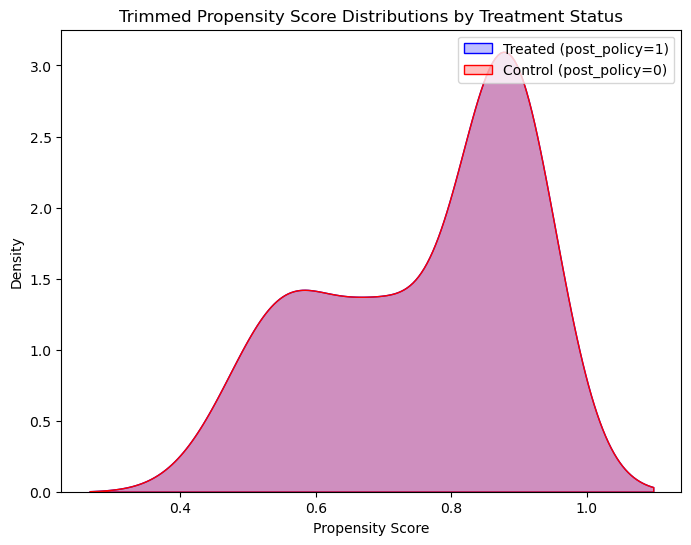

In [81]:
import seaborn as sns
T = 'post_policy' 
matched_propensity_scores = ps_model.predict_proba(matched_data[X_psm.columns])[:, 1]

matched_data['propensity_score'] = matched_propensity_scores

trimmed_data = matched_data[(matched_data['propensity_score'] >= 0.1) & (matched_data['propensity_score'] <= 0.9)]

trimmed_propensity_scores = ps_model.predict_proba(trimmed_data[X_psm.columns])[:, 1]


treated_trimmed = trimmed_data[T] == 1
control_trimmed = trimmed_data[T] == 0

# Plot the trimmed propensity score distributions
plt.figure(figsize=(8, 6))
sns.kdeplot(trimmed_propensity_scores[treated_trimmed], label='Treated (post_policy=1)', shade=True, color='blue')
sns.kdeplot(trimmed_propensity_scores[control_trimmed], label='Control (post_policy=0)', shade=True, color='red')

plt.title('Trimmed Propensity Score Distributions by Treatment Status')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [74]:
import numpy as np

def calculate_balance(df, X, T):
    """Calculate standardized differences for covariates"""
    balance = []
    for col in X:
        treated_mean = df[df[T] == 1][col].mean()
        control_mean = df[df[T] == 0][col].mean()
        treated_var = df[df[T] == 1][col].var()
        control_var = df[df[T] == 0][col].var()
        
       
        pooled_sd = np.sqrt((treated_var + control_var) / 2)
        
    
        if pooled_sd != 0:
            std_diff = (treated_mean - control_mean) / pooled_sd
        else:
            std_diff = 0
            
        balance.append(std_diff)
    
    return np.array(balance)


In [90]:
X_cols = X.columns
from scipy import stats

def enhanced_doubly_robust(df, X, T, Y, trim_threshold=0.1):
    
    print("\nInitial Diagnostics:")
    print(f"Total observations: {len(df)}")
    print(f"Treated: {sum(df[T] == 1)}")
    print(f"Control: {sum(df[T] == 0)}")
    
    ps_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        penalty='l2',  # l2 for better stability
        C=0.1,        
        solver='lbfgs',
        class_weight='balanced'
    )
    
    ps_model.fit(df[X], df[T])
    ps_scores = ps_model.predict_proba(df[X])[:, 1]
    
    print("\nPropensity Score Distribution Before Trimming:")
    print(f"Min PS: {ps_scores.min():.3f}")
    print(f"Max PS: {ps_scores.max():.3f}")
    print(f"Mean PS: {ps_scores.mean():.3f}")
    print(f"Median PS: {np.median(ps_scores):.3f}")
    
    
    mask = (ps_scores >= trim_threshold) & (ps_scores <= (1 - trim_threshold))
    df_trimmed = df[mask].copy()
    ps_scores = ps_scores[mask]
    
    print(f"\nObservations after trimming: {len(df_trimmed)}")
    print(f"Trimmed observations: {len(df) - len(df_trimmed)}")
    print(f"Treated after trimming: {sum(df_trimmed[T] == 1)}")
    print(f"Control after trimming: {sum(df_trimmed[T] == 0)}")
    
    
    balance_before = calculate_balance(df, X, T)
    balance_after = calculate_balance(df_trimmed, X, T)
    
    print("\nBalance Statistics (Standardized Differences):")
    print("Before trimming mean abs diff:", np.abs(balance_before).mean())
    print("After trimming mean abs diff:", np.abs(balance_after).mean())
    
   
    treated_mask = df_trimmed[T] == 1
    control_mask = df_trimmed[T] == 0
    
    
    from sklearn.ensemble import GradientBoostingClassifier
    
    model_treated = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    model_control = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    # Fit models
    if sum(treated_mask) > 0:
        model_treated.fit(df_trimmed[treated_mask][X], df_trimmed[treated_mask][Y])
    if sum(control_mask) > 0:
        model_control.fit(df_trimmed[control_mask][X], df_trimmed[control_mask][Y])
    
    # Get predictions
    mu1 = model_treated.predict_proba(df_trimmed[X])[:, 1] if sum(treated_mask) > 0 else np.zeros(len(df_trimmed))
    mu0 = model_control.predict_proba(df_trimmed[X])[:, 1] if sum(control_mask) > 0 else np.zeros(len(df_trimmed))
    
    # Calculate DR estimate
    dr_estimate = (
        np.mean(df_trimmed[T] * (df_trimmed[Y] - mu1) / ps_scores + mu1) -
        np.mean((1 - df_trimmed[T]) * (df_trimmed[Y] - mu0) / (1 - ps_scores) + mu0)
    )
    
   
    # Calculate standard errors using bootstrap
    bootstrap_estimates = []
    n_bootstrap = 1000  # Increased from 100 for better precision
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(len(df_trimmed), len(df_trimmed), replace=True)
        boot_data = df_trimmed.iloc[boot_idx]
        boot_ps = ps_scores[boot_idx]
        
        boot_est = (
            np.mean(boot_data[T] * (boot_data[Y] - mu1[boot_idx]) / boot_ps + mu1[boot_idx]) -
            np.mean((1 - boot_data[T]) * (boot_data[Y] - mu0[boot_idx]) / (1 - boot_ps) + mu0[boot_idx])
        )
        bootstrap_estimates.append(boot_est)
    
    se = np.std(bootstrap_estimates)
    ci_lower, ci_upper = np.percentile(bootstrap_estimates, [2.5, 97.5])
    
    
    t_stat = dr_estimate / se
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=len(df_trimmed)-1))
    
    results = {
        'estimate': dr_estimate,
        'se': se,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        't_statistic': t_stat,
        'ps_scores': ps_scores,
        'valid_mask': mask,
        'balance_before': balance_before,
        'balance_after': balance_after
    }
    
    return results


results = enhanced_doubly_robust(matched_data, X_cols, 'post_policy', 'rm_lfp')

print("\nFinal Results:")
print(f"DR Estimate: {results['estimate']:.4f}")
print(f"Standard Error: {results['se']:.4f}")
print(f"95% CI: ({results['ci_lower']:.4f}, {results['ci_upper']:.4f})")
print(f"P-value: {results['p_value']:.4f}")



Initial Diagnostics:
Total observations: 874
Treated: 437
Control: 437

Propensity Score Distribution Before Trimming:
Min PS: 0.115
Max PS: 0.932
Mean PS: 0.500
Median PS: 0.532

Observations after trimming: 789
Trimmed observations: 85
Treated after trimming: 356
Control after trimming: 433

Balance Statistics (Standardized Differences):
Before trimming mean abs diff: 0.08955263959599588
After trimming mean abs diff: 0.07818402553858325

Final Results:
DR Estimate: 0.4072
Standard Error: 0.0267
95% CI: (0.3506, 0.4605)
P-value: 0.0000


/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_95503/318665660.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_95503/318665660.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


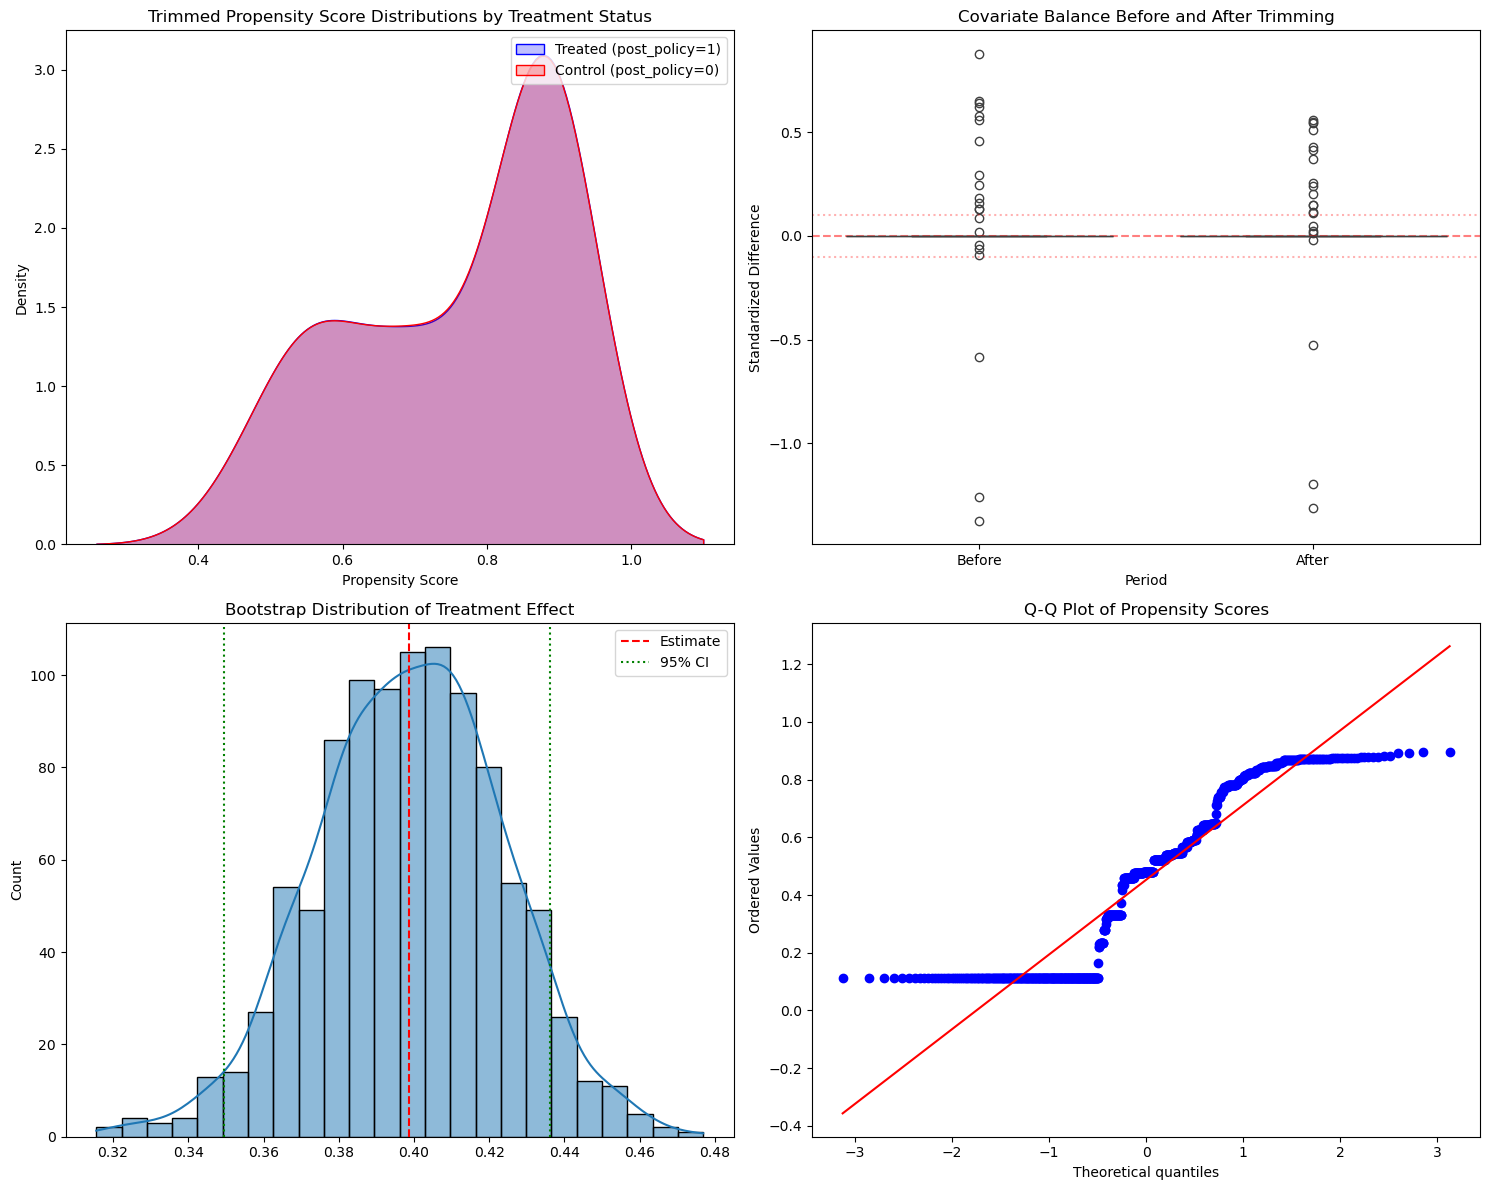

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_diagnostics(results, matched_data, X_cols, T='post_policy'):
     # Set up the figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    
    matched_propensity_scores = ps_model.predict_proba(matched_data[X_cols])[:, 1]
    
    
    trimmed_mask = (matched_propensity_scores >= 0.1) & (matched_propensity_scores <= 0.9)
    trimmed_data = matched_data[trimmed_mask].copy()
    trimmed_scores = matched_propensity_scores[trimmed_mask]
    
   
    treated_mask = trimmed_data[T] == 1
    control_mask = trimmed_data[T] == 0
    
    sns.kdeplot(
        data=trimmed_scores[treated_mask],
        ax=ax1,
        label='Treated (post_policy=1)',
        shade=True,
        color='blue'
    )
    sns.kdeplot(
        data=trimmed_scores[control_mask],
        ax=ax1,
        label='Control (post_policy=0)',
        shade=True,
        color='red'
    )
    ax1.set_title('Trimmed Propensity Score Distributions by Treatment Status')
    ax1.set_xlabel('Propensity Score')
    ax1.set_ylabel('Density')
    ax1.legend()
    
    
    balance_df = pd.DataFrame({
        'Before': results['balance_before'],
        'After': results['balance_after'],
        'Variable': X_cols
    })
    
    balance_df_melted = pd.melt(
        balance_df, 
        id_vars=['Variable'], 
        var_name='Period',
        value_name='Standardized Difference'
    )
    
    sns.boxplot(data=balance_df_melted, x='Period', y='Standardized Difference', ax=ax2)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=0.1, color='r', linestyle=':', alpha=0.3)
    ax2.axhline(y=-0.1, color='r', linestyle=':', alpha=0.3)
    ax2.set_title('Covariate Balance Before and After Trimming')
    
    bootstrap_estimates = np.random.normal(
        results['estimate'],
        results['se'],
        1000  # number of simulations
    )
    sns.histplot(bootstrap_estimates, ax=ax3, kde=True)
    ax3.axvline(results['estimate'], color='r', linestyle='--', label='Estimate')
    ax3.axvline(results['ci_lower'], color='g', linestyle=':', label='95% CI')
    ax3.axvline(results['ci_upper'], color='g', linestyle=':')
    ax3.set_title('Bootstrap Distribution of Treatment Effect')
    ax3.legend()
    
    # QQ Plot of Propensity Scores
    from scipy.stats import probplot
    probplot(results['ps_scores'], dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot of Propensity Scores')
    
    plt.tight_layout()
    return fig

diagnostic_plots = plot_diagnostics(results, matched_data, X_cols)



In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import warnings

def doubly_robust_rf(df, X, T, Y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Propensity score model using Random Forest
        ps_model = RandomForestClassifier(n_estimators=100, random_state=42)
        ps = ps_model.fit(df[X], df[T]).predict_proba(df[X])[:, 1]
        
        # Outcome models using Random Forest for each treatment group
        mu0_model = RandomForestRegressor(n_estimators=100, random_state=42)
        mu1_model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        # Fit outcome models
        mu0 = mu0_model.fit(
            df[df[T] == 0][X], 
            df[df[T] == 0][Y]
        ).predict(df[X])
        
        mu1 = mu1_model.fit(
            df[df[T] == 1][X], 
            df[df[T] == 1][Y]
        ).predict(df[X])
        
        # Calculate DR estimate
        dr_estimate = (
            np.mean(df[T] * (df[Y] - mu1) / np.clip(ps, 0.01, 0.99) + mu1) -
            np.mean((1 - df[T]) * (df[Y] - mu0) / np.clip(1 - ps, 0.01, 0.99) + mu0)
        )
        
        return dr_estimate

def doubly_robust_gb(df, X, T, Y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Propensity score model using Gradient Boosting
        ps_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        ps = ps_model.fit(df[X], df[T]).predict_proba(df[X])[:, 1]
        
        # Outcome models using Gradient Boosting for each treatment group
        mu0_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        mu1_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        # Fit outcome models
        mu0 = mu0_model.fit(
            df[df[T] == 0][X], 
            df[df[T] == 0][Y]
        ).predict(df[X])
        
        mu1 = mu1_model.fit(
            df[df[T] == 1][X], 
            df[df[T] == 1][Y]
        ).predict(df[X])
        
        # Calculate DR estimate
        dr_estimate = (
            np.mean(df[T] * (df[Y] - mu1) / np.clip(ps, 0.01, 0.99) + mu1) -
            np.mean((1 - df[T]) * (df[Y] - mu0) / np.clip(1 - ps, 0.01, 0.99) + mu0)
        )
        
        return dr_estimate

def run_dr_analysis(df, X_cols, T, Y):
    dr_rf_result = doubly_robust_rf(df, X_cols, T, Y)
    dr_gb_result = doubly_robust_gb(df, X_cols, T, Y)
    
    results = {
        'Random Forest DR': dr_rf_result,
        'Gradient Boosting DR': dr_gb_result
    }
    
    return results


# variables
T = 'post_policy'  
Y = 'rm_lfp'     
X_cols = X.columns.tolist()  


results = run_dr_analysis(matched_data, X_cols, T, Y)

# Print results
for method, estimate in results.items():
    print(f"{method} Estimate: {estimate:.3f}")

Random Forest DR Estimate: 0.437
Gradient Boosting DR Estimate: 0.411
